In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Device 세팅

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'mps':
    torch.mps.manual_seed(1)

print(device)

mps


### 모델 및 학습 정의

In [3]:
DROP_OUT_R = 0.5
LEARNING_RATE = 0.001

EPOCHS = 500
BATCH_SIZE = 50
#VALIDATION_RATE = 0.1

CHECK_INTERVAL = 10
# EARLY_STOP = 30

In [4]:
FNN_10N = nn.Sequential(
    nn.Linear(10,10),
    nn.Dropout(DROP_OUT_R),
    nn.LeakyReLU(),
    nn.Linear(10,1),
    nn.LeakyReLU()
).to(device)

In [5]:
# 파라미터 개수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(FNN_10N)) #사용

121


In [6]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(FNN_10N.parameters(), lr=LEARNING_RATE)

### 학습 과정 정의

In [7]:
train_losses = []

In [8]:
def train_model(train_loader, epochs, check_interval):
    
    for e in range(epochs):
        train_loss = 0
        
        FNN_10N.train()
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred_y = FNN_10N(x_batch)
            loss = loss_func(pred_y, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            
            train_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)
        
        if (e % check_interval) == 0:
            print("epoch : ", e, "train loss: ",train_losses[-1])

### Custom Dataset Type 정의

In [9]:
class BAT_DATASET(Dataset):
    def __init__(self, X, y):
        super().__init__()
        X = deepcopy(X)
        y = deepcopy(y)
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, index):
        rX = self.X[index]
        ry = self.y[index]

        return rX, ry
        

### 데이터 묶기 (10개씩)

In [10]:
# 10개의 Voltage_measured로 다음 번째의 Capacity를 예측
# Voltage_measure 10개씩 묶어 준비 n개 준비
# Capacity도 n개 준비

def prepareXY(X_ndArray, y_ndArray):
   X_data = list()

   for idx in range(0,len(X_ndArray), 10):
      X_data.append(X_ndArray[idx: idx+10].T) # Transpose필요, FNN에 10 seq_length를 넣음 (즉, 10 feature처럼)

   X_data = np.array(X_data)

   return X_data, y_ndArray

### ----- ⚠️ 파라미터 불러오기 ------------------------

params = torch.load("./FNN1_params.pt")
FNN1_forB0005.load_state_dict(params)

### ----- B0006/B0007/B00018 데이터 학습 ------

In [11]:
def all_data_train_wrapper():
    data_file_indices = ["B0006", "B0007", "B0018"]

    for d_idx in data_file_indices: 
        
        x_df = pd.read_csv(f"./Data/DataFrame/{d_idx}_charge_df.csv").loc[:,["cycle", "voltage_measured", "time"]]
        y_df = pd.read_csv(f"./Data/DataFrame/{d_idx}_capacity_df.csv").loc[:,["capacity"]]

        x_df_10points = pd.DataFrame(columns=x_df.columns)

        for cyc in x_df["cycle"].unique():
            tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
            interval = len(tmp_cycle_x_df.index)//10
            choosed_idx = []
            for idx in range(0,len(tmp_cycle_x_df), interval):
                if len(choosed_idx) == 10 :
                        break
                choosed_idx.append(idx)

            x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)

        
        display(x_df_10points)

        X_scaler = MinMaxScaler(feature_range=(0,1))
        y_scaler = MinMaxScaler(feature_range=(0,1))

        RAW_XDATA = deepcopy(x_df_10points)
        RAW_yDATA = deepcopy(y_df)

        X_scaled = X_scaler.fit_transform(RAW_XDATA["voltage_measured"].values.reshape(-1,1))
        y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))

        X_data, y_data= prepareXY(X_scaled, y_scaled)
        X_data = torch.from_numpy(X_data).type(torch.float).reshape(-1,10)
        y_data = torch.from_numpy(y_data).type(torch.float)

        train_dataset = BAT_DATASET(X_data, y_data)

        train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=False)

        train_model(train_loader, EPOCHS, CHECK_INTERVAL)

In [12]:
all_data_train_wrapper()

,cycle,voltage_measured,time
76,2,3.772765,234.078
152,2,3.869867,511.156
228,2,3.928052,875.062
304,2,3.968767,1364.266
380,2,4.013166,1994.187
...,...,...,...
375852,169,4.199172,4206.797
376108,169,4.199734,4952.406
376364,169,4.199159,5697.531
376620,169,4.196670,6443.437


epoch :  0 train loss:  0.19139789789915085
epoch :  10 train loss:  0.13414148427546024
epoch :  20 train loss:  0.12154895160347223
epoch :  30 train loss:  0.1377533245831728
epoch :  40 train loss:  0.12010030541568995
epoch :  50 train loss:  0.12067302968353033
epoch :  60 train loss:  0.10587820317596197
epoch :  70 train loss:  0.10473904758691788
epoch :  80 train loss:  0.08462041709572077
epoch :  90 train loss:  0.0881506260484457
epoch :  100 train loss:  0.10559889487922192
epoch :  110 train loss:  0.09881708305329084
epoch :  120 train loss:  0.08230034355074167
epoch :  130 train loss:  0.08516662195324898
epoch :  140 train loss:  0.06982542667537928
epoch :  150 train loss:  0.07764186942949891
epoch :  160 train loss:  0.06480426480993629
epoch :  170 train loss:  0.06848365534096956
epoch :  180 train loss:  0.06676410231739283
epoch :  190 train loss:  0.06999417534098029
epoch :  200 train loss:  0.07045041909441352
epoch :  210 train loss:  0.049644704442471266


,cycle,voltage_measured,time
76,2,3.785553,234.078
152,2,3.881019,511.156
228,2,3.937696,875.062
304,2,3.978918,1364.266
380,2,4.028100,1994.187
...,...,...,...
375852,169,4.212398,4206.797
376108,169,4.213197,4952.406
376364,169,4.211974,5697.531
376620,169,4.210804,6443.437


epoch :  0 train loss:  0.07783399196341634
epoch :  10 train loss:  0.0555668247397989
epoch :  20 train loss:  0.047267711255699396
epoch :  30 train loss:  0.04551086970604956
epoch :  40 train loss:  0.045391373336315155
epoch :  50 train loss:  0.039860085817053914
epoch :  60 train loss:  0.043127358658239245
epoch :  70 train loss:  0.044019944267347455
epoch :  80 train loss:  0.044346479466184974
epoch :  90 train loss:  0.04705280181951821
epoch :  100 train loss:  0.04678524937480688
epoch :  110 train loss:  0.049211126985028386
epoch :  120 train loss:  0.04501033527776599
epoch :  130 train loss:  0.048714891308918595
epoch :  140 train loss:  0.041498212376609445
epoch :  150 train loss:  0.04384209052659571
epoch :  160 train loss:  0.04300704482011497
epoch :  170 train loss:  0.038822534494102
epoch :  180 train loss:  0.04101928835734725
epoch :  190 train loss:  0.04918622621335089
epoch :  200 train loss:  0.03877580212429166
epoch :  210 train loss:  0.04007166624

,cycle,voltage_measured,time
257,2,3.938450,653.547
514,2,3.997673,1303.219
771,2,4.049742,1952.907
1028,2,4.124331,2602.360
1285,2,4.199741,3287.219
...,...,...,...
190702,134,4.198810,4252.766
190802,134,4.200036,4977.859
190902,134,4.199606,5706.000
191002,134,4.199994,6431.531


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (130, 1) + inhomogeneous part.

### ----- ⚠️ 새로운 파라미터 저장 ------------------------

FNN_10N_params = FNN_10N.state_dict()
torch.save(FNN_10N_params, "./BEST_MODEL/FNN_10N_params.pt")

### B0005 예측

In [ ]:
x_df = pd.read_csv(f"./Data/DataFrame/B0005_charge_df.csv").loc[:,["cycle", "voltage_measured", "time"]]
y_df = pd.read_csv(f"./Data/DataFrame/B0005_capacity_df.csv").loc[:,["capacity"]]

x_df_10points = pd.DataFrame(columns=x_df.columns)
for cyc in x_df["cycle"].unique():
    tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
    interval = len(tmp_cycle_x_df.index)//10
    choosed_idx = []
    for idx in range(0,len(tmp_cycle_x_df), interval):
        if len(choosed_idx) == 10 :
            break
        choosed_idx.append(idx)

    x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)    
display(x_df_10points)

X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

RAW_XDATA = deepcopy(x_df_10points)
RAW_yDATA = deepcopy(y_df)

X_scaled = X_scaler.fit_transform(RAW_XDATA["voltage_measured"].values.reshape(-1,1))
y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))
        
X_data, y_data= prepareXY(X_scaled, y_scaled)
X_data = torch.from_numpy(X_data).type(torch.float).reshape(-1,10)
y_data = torch.from_numpy(y_data).type(torch.float)

test_dataset = BAT_DATASET(X_data, y_data)

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

predicts = []

FNN_10N.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
            
        pred_y = FNN_10N(x_batch)

        predicts.append(pred_y.to('cpu'))

predicts_concat = torch.cat(predicts, 0)
predicts_df = pd.DataFrame(y_scaler.inverse_transform(np.array(predicts_concat)))


,cycle,voltage_measured,time
0,2,3.434644,5.500
76,2,3.814079,234.078
152,2,3.881686,511.156
228,2,3.937241,875.062
304,2,3.979605,1364.266
...,...,...,...
375596,169,4.205285,3460.406
375852,169,4.205106,4206.797
376108,169,4.204985,4952.406
376364,169,4.206357,5697.531


In [ ]:
predicts_df

,0
0,2.001471
1,1.983825
2,1.961700
3,1.970448
4,1.977378
...,...
162,1.416525
163,1.415373
164,1.414226
165,1.413893


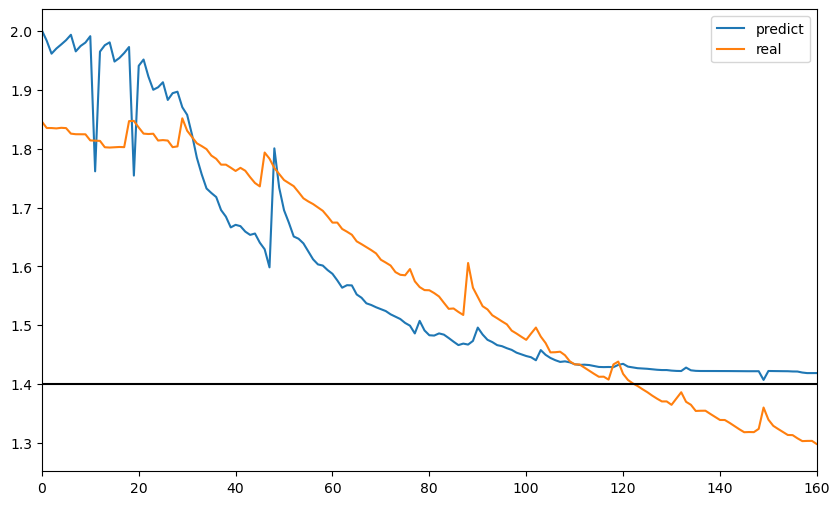

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
plt.xlim([0, 160])

plt.plot(predicts_df.index, predicts_df.iloc[:,0], label='predict')
plt.plot(range(len(y_df.index)), y_df.iloc[:,0], label='real')
plt.plot(range(len(y_df.index)), [1.4 for i in range(len(y_df.index))], color='black')

plt.legend()
plt.show()

predicts_df.to_csv("./PREDICT/FNN_10N.csv", index = False)